### The goal of this notebook is to explore the results of the 1, 10, 100 and 1000 negative examples to 1 positive example
* We will explore the ROC and PRC curves.The number of negative examples to one positive examples at a ratio of 10, 10^2, and 10^3 do not seem to affect the ROC and PRC
* We will look at the distribution of predicted scores. Scores approach zero as negative sampling ratio increases. This is expected
* We will look at the ranking at Hits@1,3,10,30 and 100. While probability prediction drops, the ranking stays relatively unchanged.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from data_tools import plotting as pt
from statistics import mean
from tqdm import tqdm

/home/rogertu/projects/MechRepoNet/mrn_venv/lib/python3.8/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
%%time
pairs0001 = pd.read_csv(os.path.join('../2_pipeline/','14b_Model_Eval_Holdout_Set_1to1','out','results.csv'))
pairs0010 = pd.read_csv(os.path.join('../2_pipeline/','14b_Model_Eval_Holdout_Set_10to1','out','results.csv'))
pairs0100 = pd.read_csv(os.path.join('../2_pipeline/','14b_Model_Eval_Holdout_Set','out','results.csv'))
pairs1000 = pd.read_csv(os.path.join('../2_pipeline/','14b_Model_Eval_Holdout_Set_1000to1','out','results.csv'))

CPU times: user 22.7 s, sys: 3.75 s, total: 26.4 s
Wall time: 26.4 s


In [4]:
zero_prob1000 = pairs1000['proba'].value_counts().index[0]
zero_prob0100 = pairs0100['proba'].value_counts().index[0]
zero_prob0010 = pairs0010['proba'].value_counts().index[0]
zero_prob0001 = pairs0001['proba'].value_counts().index[0]

In [5]:
y1 = pairs0001.query('proba !=@zero_prob0001')['status']
y10 = pairs0010.query('proba !=@zero_prob0010')['status']
y100 = pairs0100.query('proba !=@zero_prob0100')['status']
y1000 = pairs1000.query('proba !=@zero_prob1000')['status']

In [6]:
y_proba1 = pairs0001.query('proba != @zero_prob0001')['proba']
y_proba10 = pairs0010.query('proba != @zero_prob0010')['proba']
y_proba100 = pairs0100.query('proba != @zero_prob0100')['proba']
y_proba1000 = pairs1000.query('proba != @zero_prob1000')['proba']

In [7]:
# quick check to see if all sets are even
pairs0010['status'].sum()==pairs0100['status'].sum()==pairs1000['status'].sum()==pairs0001['status'].sum()

True

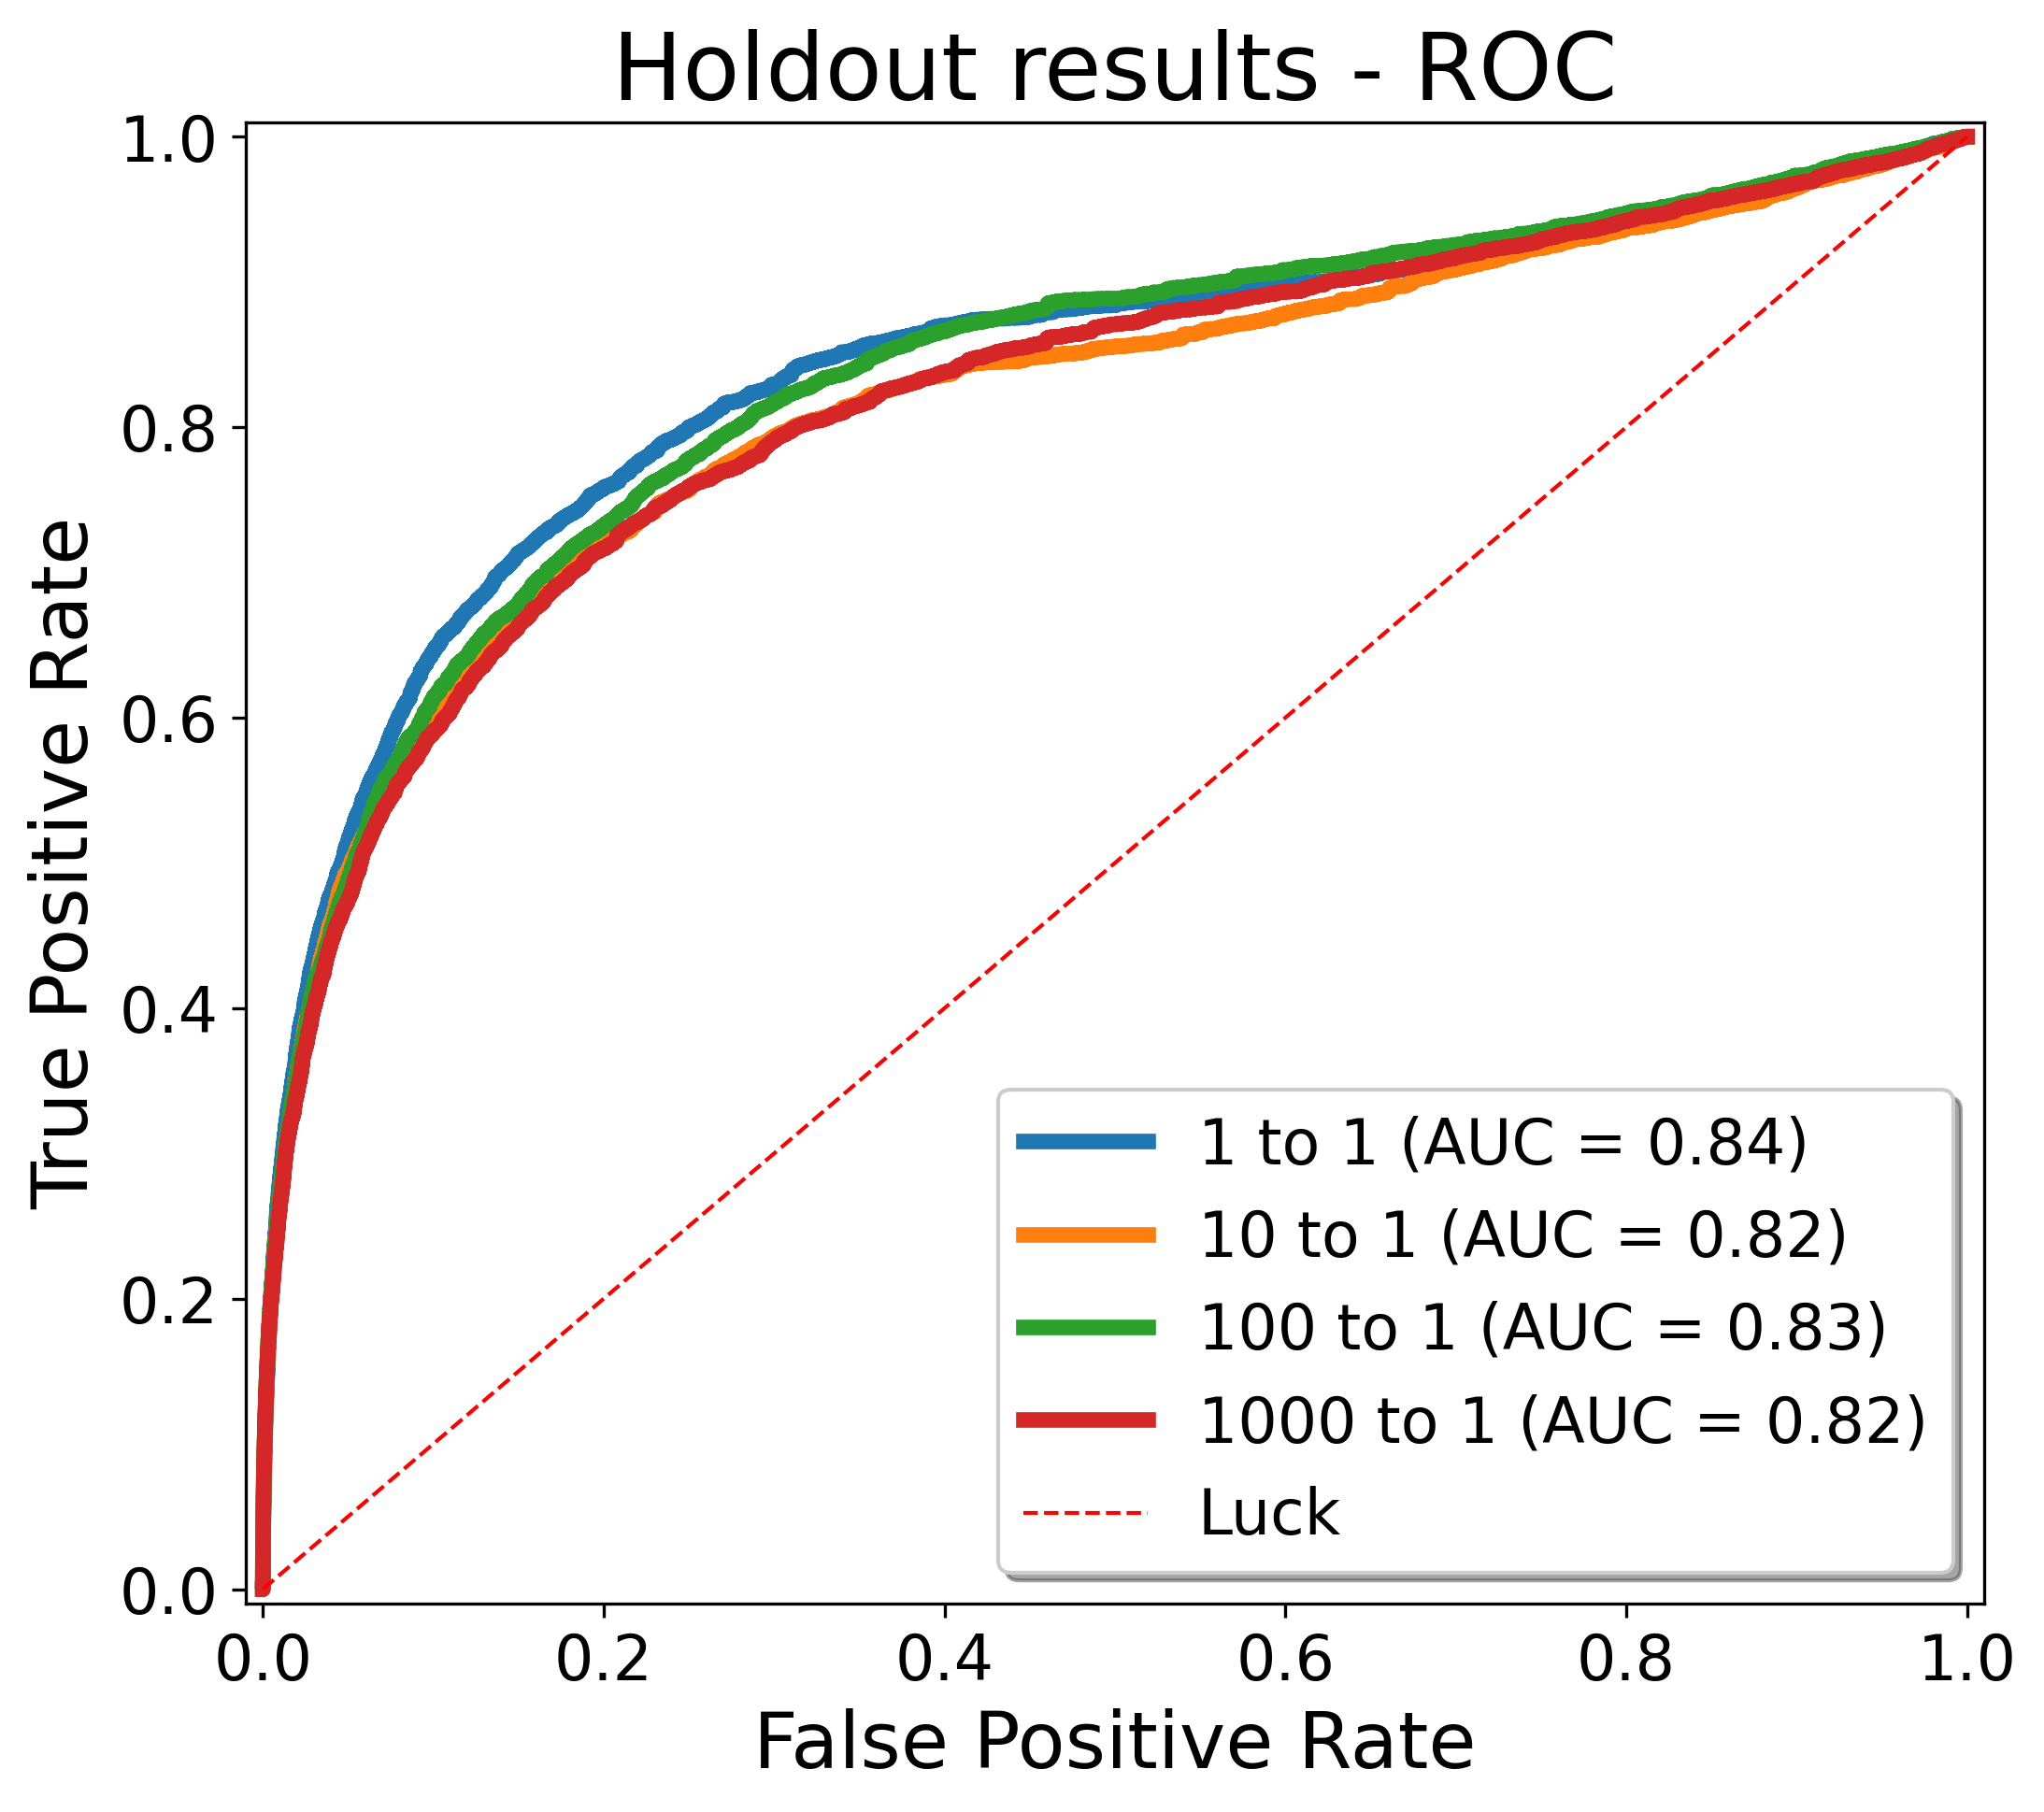

In [8]:
pt.graph_single_roc(y1, y_proba1, '1 to 1')
pt.graph_single_roc(y10, y_proba10, '10 to 1')
pt.graph_single_roc(y100, y_proba100, '100 to 1')
pt.graph_single_roc(y1000, y_proba1000, '1000 to 1')

pt.graph_roc_boilerplate('Holdout results - ROC');

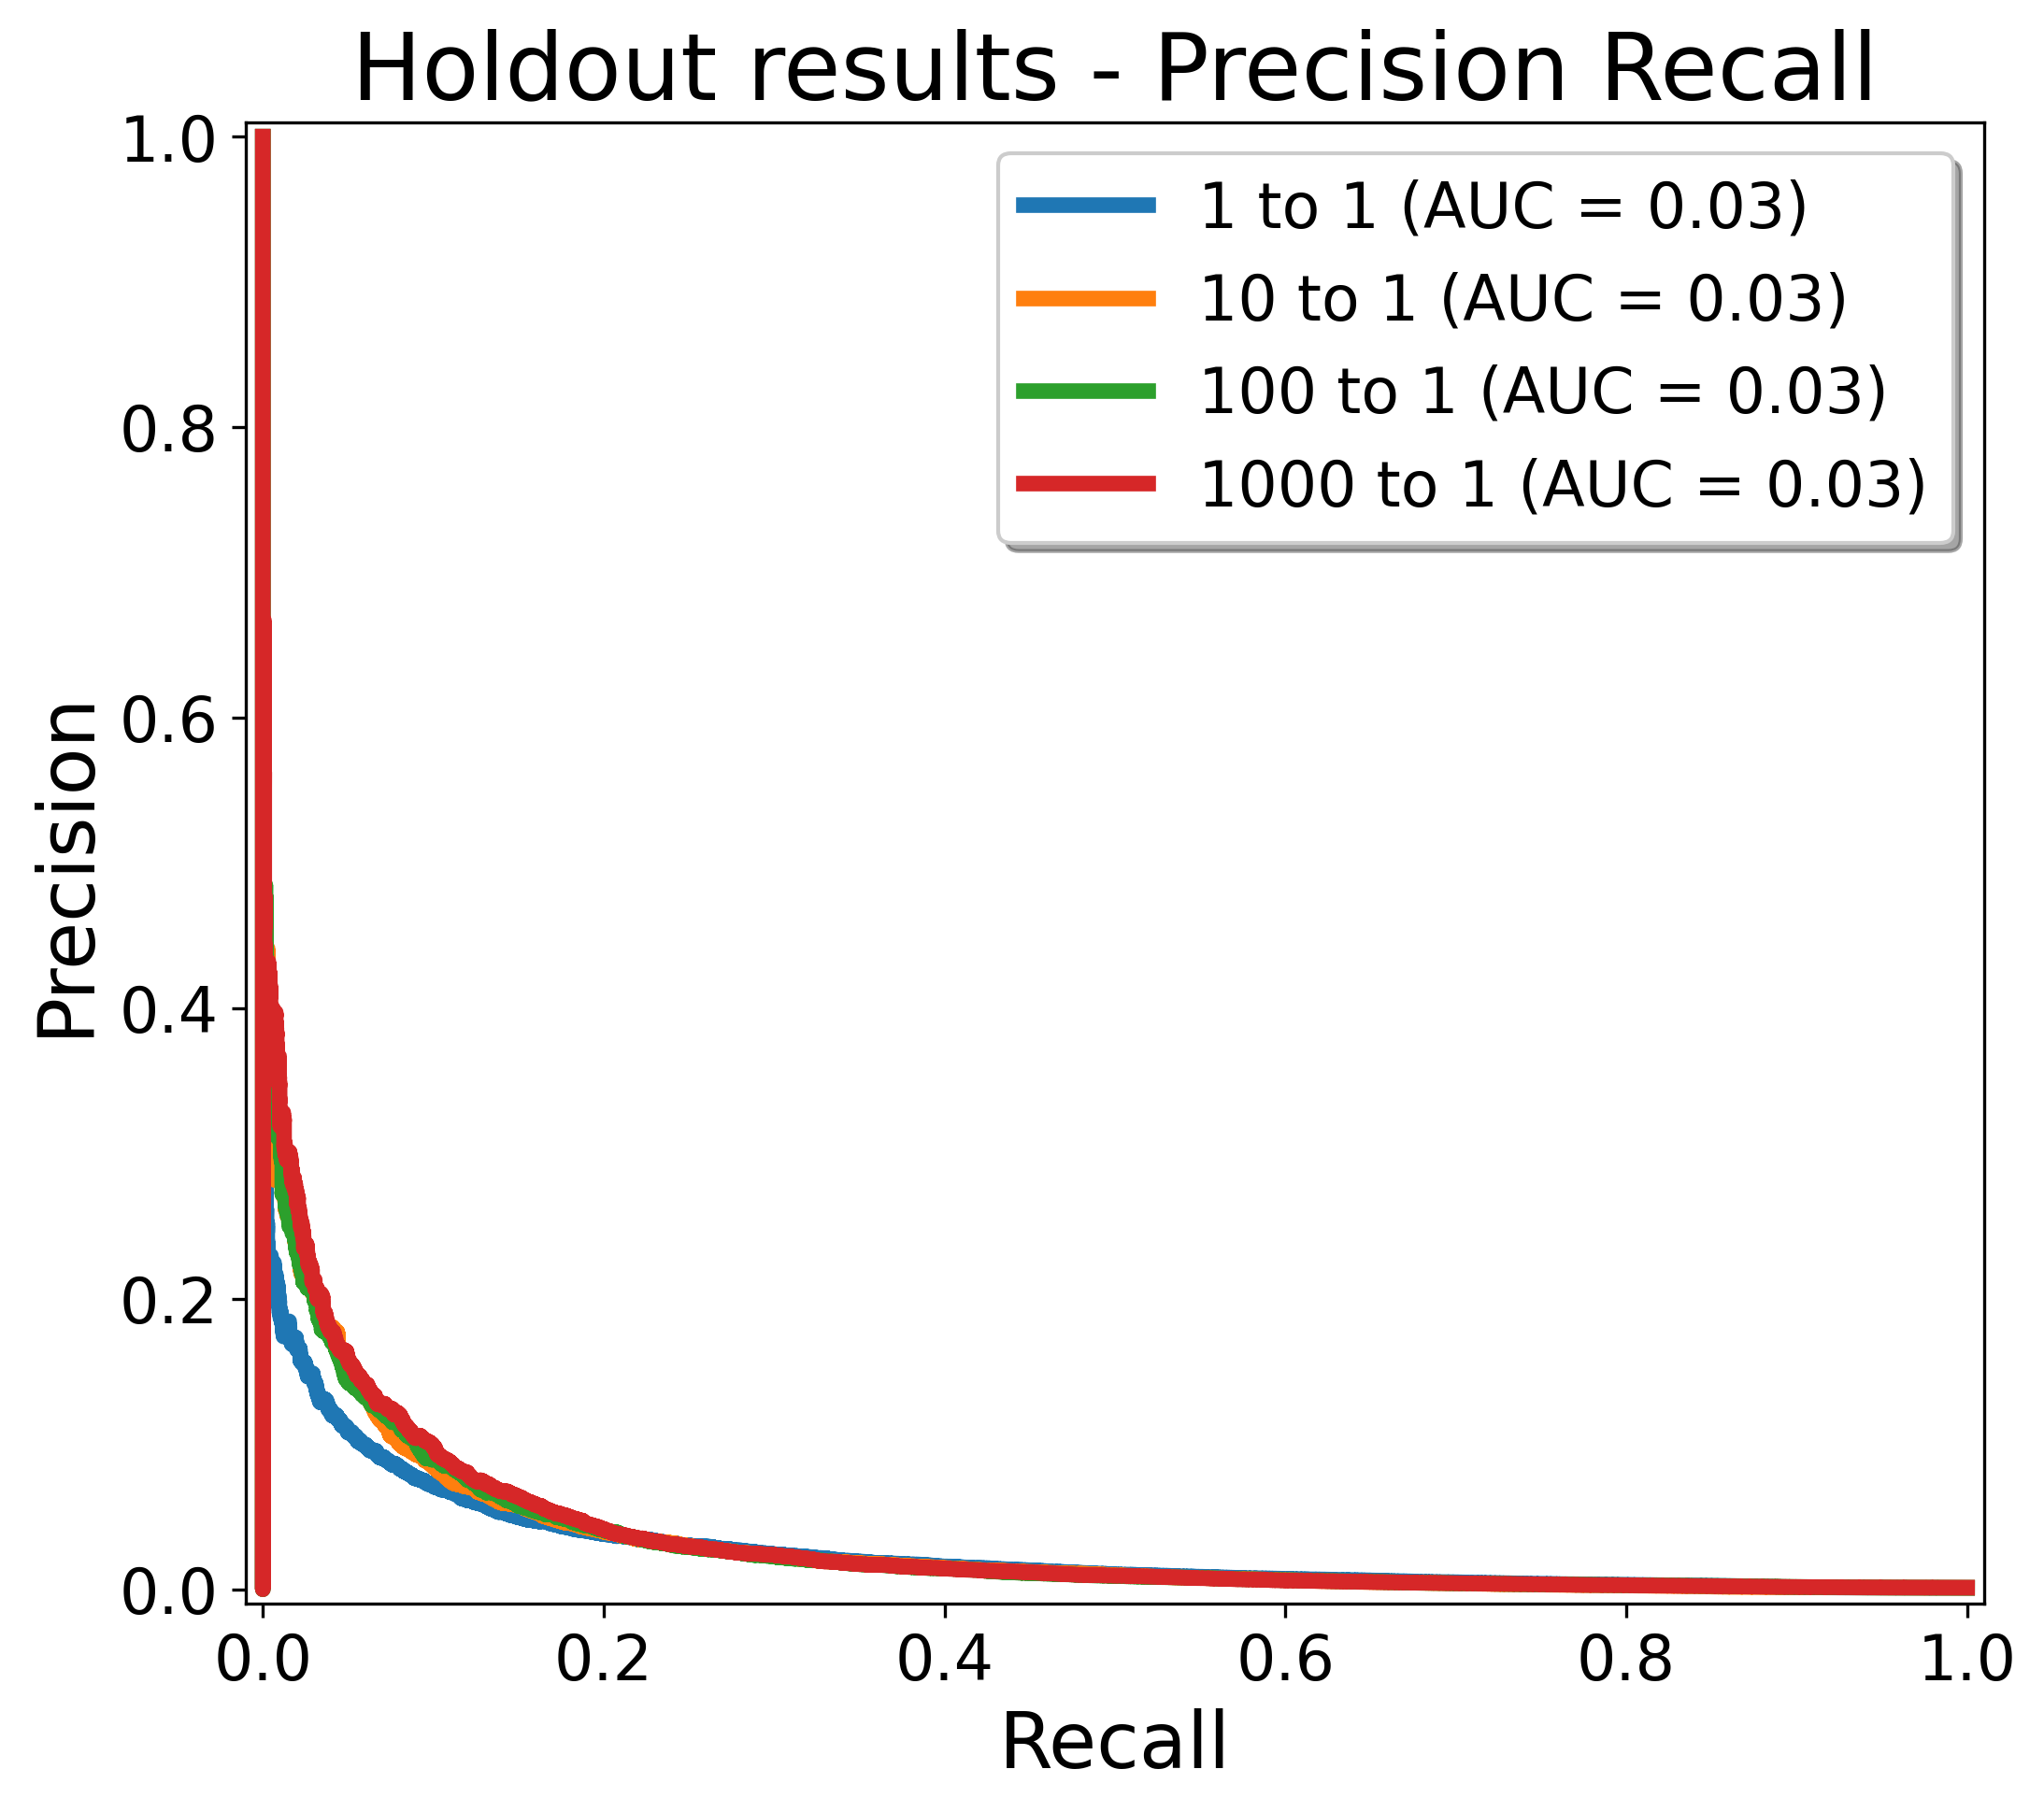

In [9]:
pt.graph_single_prc(y1, y_proba1, '1 to 1')
pt.graph_single_prc(y10, y_proba10, '10 to 1')
pt.graph_single_prc(y100, y_proba100, '100 to 1')
pt.graph_single_prc(y1000, y_proba1000, '1000 to 1')

pt.graph_prc_boilerplate('Holdout results - Precision Recall');

### Get Classification Values
Threshold probability by best ROC val returns:
* Best Threshold: 0.009
* true pos rate: 0.716
* false pos rate: 0.180
* Precision: 0.0039
* Recall: 0.5627

Threshold probability by best PRC val returns:
* Best Threshold: 0.287 
* F-Score: 0.096 
* Precision: 0.086
* Recall: 0.109


#### Precision and Recall based on ROC

In [10]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix

In [11]:
fpr, tpr, thresh = roc_curve(y100, y_proba100, drop_intermediate=False)

In [12]:
# Youden's J stat
J = tpr -fpr

In [13]:
# Largets Youden's val is 
ix = thresh[np.argmax(J)]
ix

0.0088425103859368

In [14]:
# True Positive Rate at threshold
tpr[np.argmax(J)]

0.7163173652694611

In [15]:
# False Positive Rate at threshold
fpr[np.argmax(J)]

0.1804263688595316

In [16]:
# Recall
cTP = pairs0100.query('proba>0.0088425103859368').status.sum() # True Pos and Pred True
cP = np.array(y_proba100>0.0088425103859368).sum() # all Predicted True
TP = pairs0100.status.sum() # All True

cTP/TP

0.5626607864755605

In [17]:
# Precision 
FP = abs(cTP-TP)
cTP/(cP)

0.003889306920934023

#### Precision and Recall using AUPRC as a threshold

In [18]:
pre, rec, threshold = precision_recall_curve(y100, y_proba100)

In [19]:
f_score = (2*pre*rec)/(pre+rec)
f_score = f_score[~np.isnan(f_score)]

/tmp/ipykernel_563027/4271115831.py:1: RuntimeWarning: invalid value encountered in true_divide
  f_score = (2*pre*rec)/(pre+rec)


In [20]:
threshold[np.argmax(f_score)]

0.2869607613409626

In [21]:
ix = np.argmax(f_score)

In [22]:
print(f'Best Threshold: {threshold[ix]:.3f} \nF-Score: {f_score[ix]:.3f} \nPrecision: {pre[ix]:.3f}\nRecall: {rec[ix]:.3f}')

Best Threshold: 0.287 
F-Score: 0.096 
Precision: 0.086
Recall: 0.109


#### generate hits@k for each set of data

In [23]:
# number of unique drugs
len(set(pairs0001['chemicalsubstance_id']))

4764

In [24]:
# number of unique diseases
len(set(pairs0001['disease_id']))

4169

In [25]:
# total df size is the multiplication of unique drug by unique disease
len(set(pairs0001['chemicalsubstance_id']))*len(set(pairs0001['disease_id']))==pairs0001.shape[0]

True

In [26]:
# check if the count of unique entities is the same
len(set(pairs0001['chemicalsubstance_id']))==len(set(pairs0010['chemicalsubstance_id']))==len(set(pairs0100['chemicalsubstance_id']))==len(set(pairs1000['chemicalsubstance_id']))

True

In [27]:
# check if each set are the same
set(pairs0001['chemicalsubstance_id'])==set(pairs0010['chemicalsubstance_id'])==set(pairs0100['chemicalsubstance_id'])==set(pairs1000['chemicalsubstance_id'])

True

In [28]:
unique_chem = list(set(pairs0001['chemicalsubstance_id']))

#### Check if all pairs regardless of sampling ratio have the same triple outputs 

In [29]:
# Check if names are the same between 1, 10, 100, 1000
pairs1_name = pairs0001.chemicalsubstance_id+'-'+pairs0001.disease_id
pairs10_name = pairs0010.chemicalsubstance_id+'-'+pairs0010.disease_id
pairs100_name = pairs0100.chemicalsubstance_id+'-'+pairs0100.disease_id
pairs1000_name = pairs1000.chemicalsubstance_id+'-'+pairs1000.disease_id

In [30]:
# Check the names are the same between 1, 10, 100, 1000
set(pairs1_name) == set(pairs10_name) == set(pairs100_name) == set(pairs1000_name)

True

In [31]:
# Check if all status are the same between 1 and 10, between 100 and 1000
# and between 10 to 100.
set(pairs0001.status == pairs0010.status) == set(pairs0100.status==pairs1000.status) == set(pairs0010.status == pairs0100.status)

True

In [32]:
# Filter for pairs that are True Chemical to Disease pairs
pairs1_stat1 = pairs0001.query('status==1')
pairs10_stat1 = pairs0010.query('status==1')
pairs100_stat1 = pairs0100.query('status==1')
pairs1000_stat1 = pairs1000.query('status==1')

In [33]:
# Check if all the shapes are the same
pairs1_stat1.shape==pairs10_stat1.shape==pairs100_stat1.shape==pairs1000_stat1.shape

True

In [34]:
# Check shape size
pairs1_stat1.shape

(13605, 4)

In [35]:
# Check for names being the same
set(pairs1_stat1.chemicalsubstance_id==pairs10_stat1.chemicalsubstance_id)

{True}

In [36]:
set(pairs10_stat1.chemicalsubstance_id==pairs100_stat1.chemicalsubstance_id)

{True}

In [37]:
set(pairs100_stat1.chemicalsubstance_id==pairs1000_stat1.chemicalsubstance_id)

{True}

#### Plot probability distribution of True Indicitations given sampling ratio

In [38]:
# Get summary stats for each pair
for i in ['pairs1_stat1', 'pairs10_stat1', 'pairs100_stat1', 'pairs1000_stat1']:
    print(f'summary stats for: {i}')
    print(eval(i).proba.describe())
#pairs1_stat1.proba.describe()

summary stats for: pairs1_stat1
count    13605.000000
mean         0.603777
std          0.269914
min          0.063858
25%          0.336506
50%          0.551881
75%          0.895776
max          0.999999
Name: proba, dtype: float64
summary stats for: pairs10_stat1
count    13605.000000
mean         0.256515
std          0.292650
min          0.008416
25%          0.055040
50%          0.095323
75%          0.359112
max          0.999994
Name: proba, dtype: float64
summary stats for: pairs100_stat1
count    13605.000000
mean         0.075577
std          0.153652
min          0.001010
25%          0.005286
50%          0.012222
75%          0.055283
max          0.977693
Name: proba, dtype: float64
summary stats for: pairs1000_stat1
count    13605.000000
mean         0.013324
std          0.045110
min          0.000081
25%          0.000555
50%          0.001177
75%          0.005646
max          0.797670
Name: proba, dtype: float64


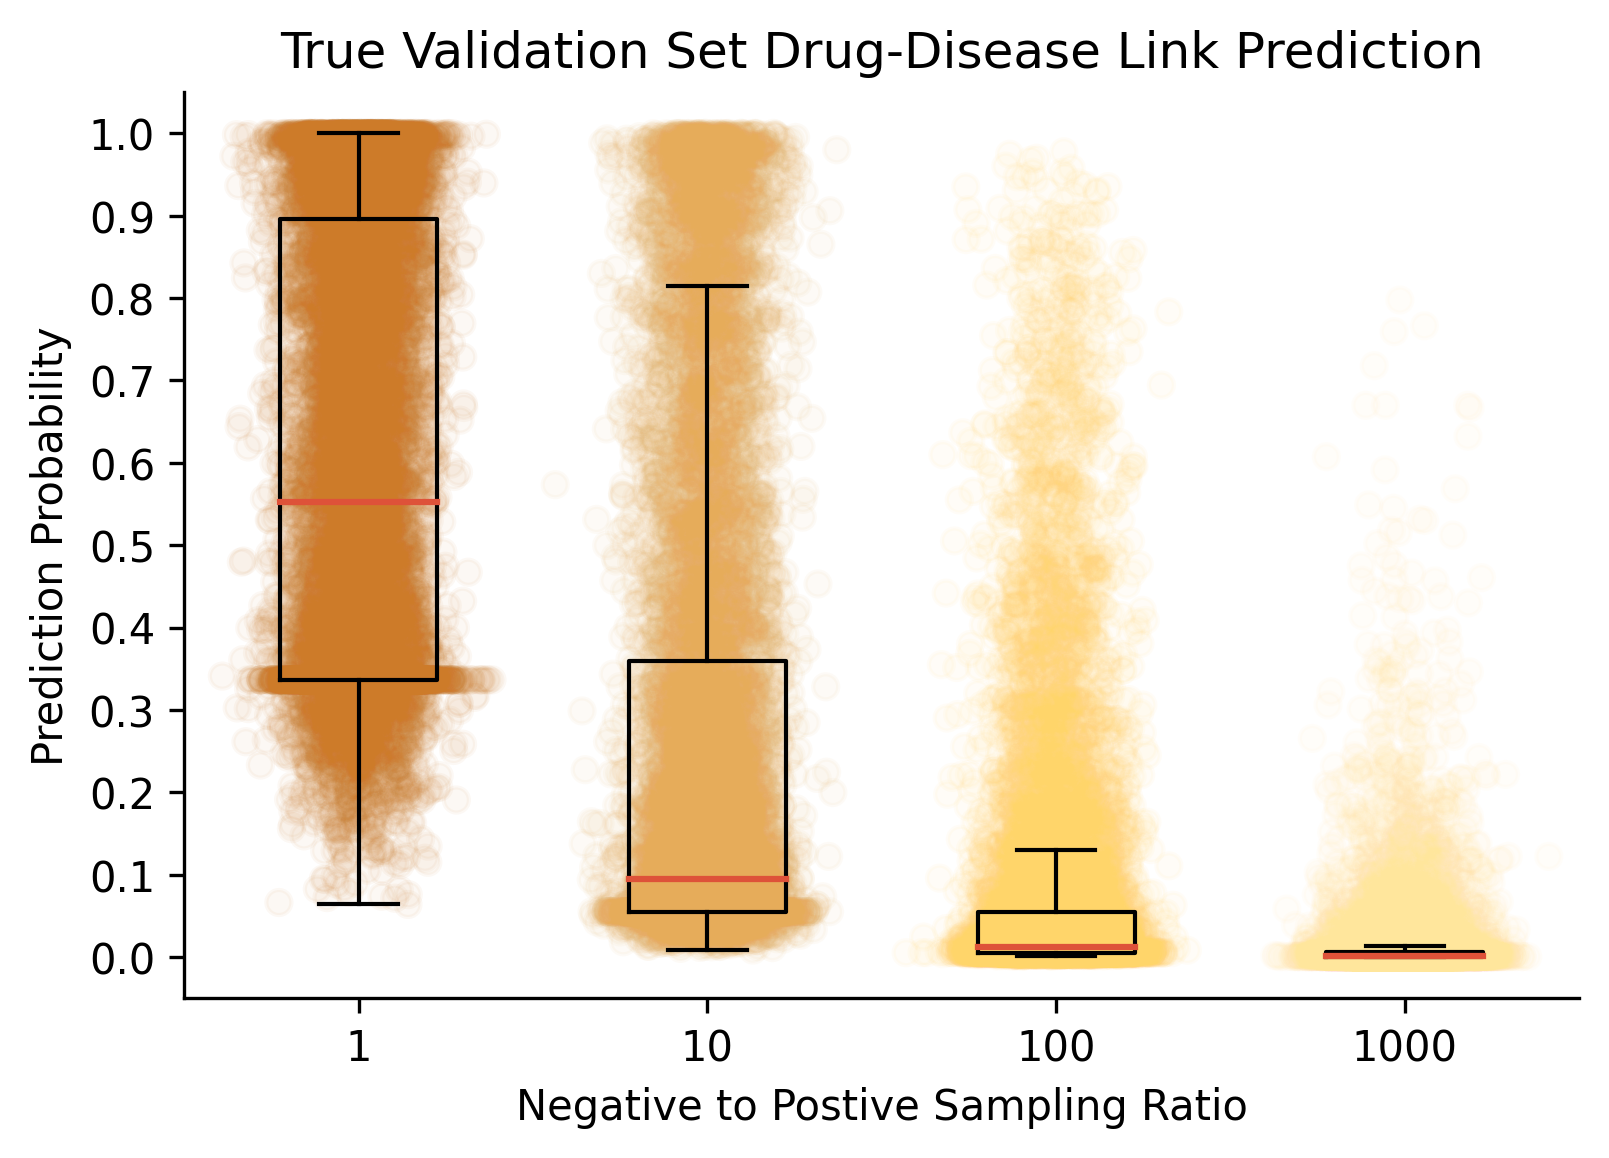

In [39]:
fig,ax = plt.subplots()
to_plot = [pairs1_stat1.proba,pairs10_stat1.proba,pairs100_stat1.proba,pairs1000_stat1.proba]

#palette = ['#3183c5','#94d5ff','#315a83','#8bc5cd'] #squirtle blues
palette = ['#cd7b29','#e6ac5a','#ffd56a','#ffe69c'] #squirtle browns

pos = np.array(range(len(to_plot)))+1


# Plot Scatter Points
labs,vals,cols = list(),list(),list()
for i,v in enumerate(to_plot):
    for v2 in v:
        labs.append(np.random.normal(loc = i+1, scale = 0.1)) # adds jitter
        vals.append(v2)
        cols.append(palette[i])

plt.scatter(x=labs,y=vals,color=cols, alpha = 0.05)


# Plot Box and Whisker
ax.boxplot(x = to_plot, positions = pos, showfliers = False,
          #flierprops = {'marker':'.', 'markeredgecolor':None, 'markerfacecolor':'gray','markersize':5, 'alpha':.5}
          medianprops = dict(linewidth = 1.5, linestyle = '-', color = '#de5239')
          )


# Labeling
ax.set_yticks(np.arange(0,1.1,.1))

ax.set_xticklabels(['1','10','100','1000'])
ax.set_xlabel('Negative to Postive Sampling Ratio')
ax.set_ylabel('Prediction Probability')
ax.set_title('True Validation Set Drug-Disease Link Prediction')

# Plot customization
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('../3_figures/neg-pos_ratio_boxplots_400dpi.png', format="png", dpi = 400, bbox_inches='tight')
plt.savefig('../3_figures/neg-pos_ratio_boxplots_800dpi.png', format="png", dpi = 800, bbox_inches='tight')
plt.show()

#### Calculate hits@k for each neg to pos ratio

In [40]:
unique_chem_dis = list(zip(pairs1_stat1['chemicalsubstance_id'],pairs1_stat1['disease_id']))

In [41]:
unique_chem_dis[0:5]

[('CHEBI:10001', 'DOID:114'),
 ('CHEBI:10002', 'DOID:326'),
 ('CHEBI:10037', 'DOID:0060180'),
 ('CHEBI:10037', 'DOID:10283'),
 ('CHEBI:10043', 'DOID:10652')]

In [42]:
def get_hits(df,unique_chemical_disease_pairs):
    '''
    '''
    # initialize your hit counts as zero
    hits1, hits3, hits10, hits30, hits100, total = 0,0,0,0,0,0
    reciprocal_ranks_list = list()
    ranks = list()
    df0 = df
    
    for i in tqdm(unique_chemical_disease_pairs):
        chem,dis = i[0],i[1]

        df = df0.query('chemicalsubstance_id==@chem').sort_values(by='proba',ascending = False)
        df = df.reset_index()
        df_item_count = df.shape[0]
        try:
            index_value = df.query('disease_id==@dis').index[0] + 1
        except:
            total +=1
            next
        df = df[0:index_value]
        rank = index_value - (sum(df.status)-1)
        reciprocal_rank = rank/df_item_count
        
    # add up hit values
        if rank <= 1:
            hits1 +=1
        if rank <= 3:
            hits3 +=1
        if rank <= 10:
            hits10 +=1
        if rank <=30:
            hits30 +=1
        if rank <=100:
            hits100 +=1
        total +=1
        reciprocal_ranks_list.append(reciprocal_rank)
        ranks.append(rank)
    # calculate hits
    hits_1   = hits1/total
    hits_3   = hits3/total
    hits_10  = hits10/total
    hits_30  = hits30/total
    hits_100 = hits100/total
    
    # calculate MRR
    mrr = mean(reciprocal_ranks_list)
    mr = mean(ranks)
    
    
    return (hits_1, hits_3, hits_10, hits_30,hits_100,mrr,mr)
    

In [43]:
h1,h3,h10,h30,h100,mrr,mr = get_hits(pairs0001,unique_chem_dis)
print(f'''
1-to-1 Negative to Positive Sampling Ratio Hits@K results:
Hits@1:   {h1:.4f}
Hits@3:   {h3:.4f}
Hits@10:  {h10:.4f}
Hits@30:  {h30:.4f}
Hits@100: {h100:.4f}
MRR:      {mrr:.4f}
MR:       {mr:.4f}
''')

100%|███████████████████████████████████████████████████████████| 13605/13605 [1:21:43<00:00,  2.77it/s]


1-to-1 Negative to Positive Sampling Ratio Hits@K results:
Hits@1:   0.0194
Hits@3:   0.0451
Hits@10:  0.0915
Hits@30:  0.1619
Hits@100: 0.2605
MRR:      0.2644
MR:       1102.0000



In [44]:
h1,h3,h10,h30,h100,mrr,mr = get_hits(pairs0010,unique_chem_dis)
print(f'''
10-to-1 Negative to Positive Sampling Ratio Hits@K results:
Hits@1:   {h1:.4f}
Hits@3:   {h3:.4f}
Hits@10:  {h10:.4f}
Hits@30:  {h30:.4f}
Hits@100: {h100:.4f}
MRR:      {mrr:.4f}
MR:       {mr:.4f}
''')

100%|███████████████████████████████████████████████████████████| 13605/13605 [1:22:22<00:00,  2.75it/s]


10-to-1 Negative to Positive Sampling Ratio Hits@K results:
Hits@1:   0.0176
Hits@3:   0.0441
Hits@10:  0.0895
Hits@30:  0.1646
Hits@100: 0.2680
MRR:      0.2753
MR:       1147.0000



In [45]:
h1,h3,h10,h30,h100,mrr,mr = get_hits(pairs0100,unique_chem_dis)
print(f'''
100-to-1 Negative to Positive Sampling Ratio Hits@K results:
Hits@1:   {h1:.4f}
Hits@3:   {h3:.4f}
Hits@10:  {h10:.4f}
Hits@30:  {h30:.4f}
Hits@100: {h100:.4f}
MRR:      {mrr:.4f}
MR:       {mr:.4f}
''')

100%|███████████████████████████████████████████████████████████| 13605/13605 [1:22:23<00:00,  2.75it/s]


100-to-1 Negative to Positive Sampling Ratio Hits@K results:
Hits@1:   0.0240
Hits@3:   0.0483
Hits@10:  0.0940
Hits@30:  0.1617
Hits@100: 0.2645
MRR:      0.2695
MR:       1123.0000



In [46]:
h1,h3,h10,h30,h100,mrr,mr = get_hits(pairs1000,unique_chem_dis)
print(f'''
1000-to-1 Negative to Positive Sampling Ratio Hits@K results:
Hits@1:   {h1:.4f}
Hits@3:   {h3:.4f}
Hits@10:  {h10:.4f}
Hits@30:  {h30:.4f}
Hits@100: {h100:.4f}
MRR:      {mrr:.4f}
MR:       {mr:.4f}
''')

100%|███████████████████████████████████████████████████████████| 13605/13605 [1:22:21<00:00,  2.75it/s]


1000-to-1 Negative to Positive Sampling Ratio Hits@K results:
Hits@1:   0.0241
Hits@3:   0.0489
Hits@10:  0.0925
Hits@30:  0.1643
Hits@100: 0.2604
MRR:      0.2737
MR:       1141.0000



In [47]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

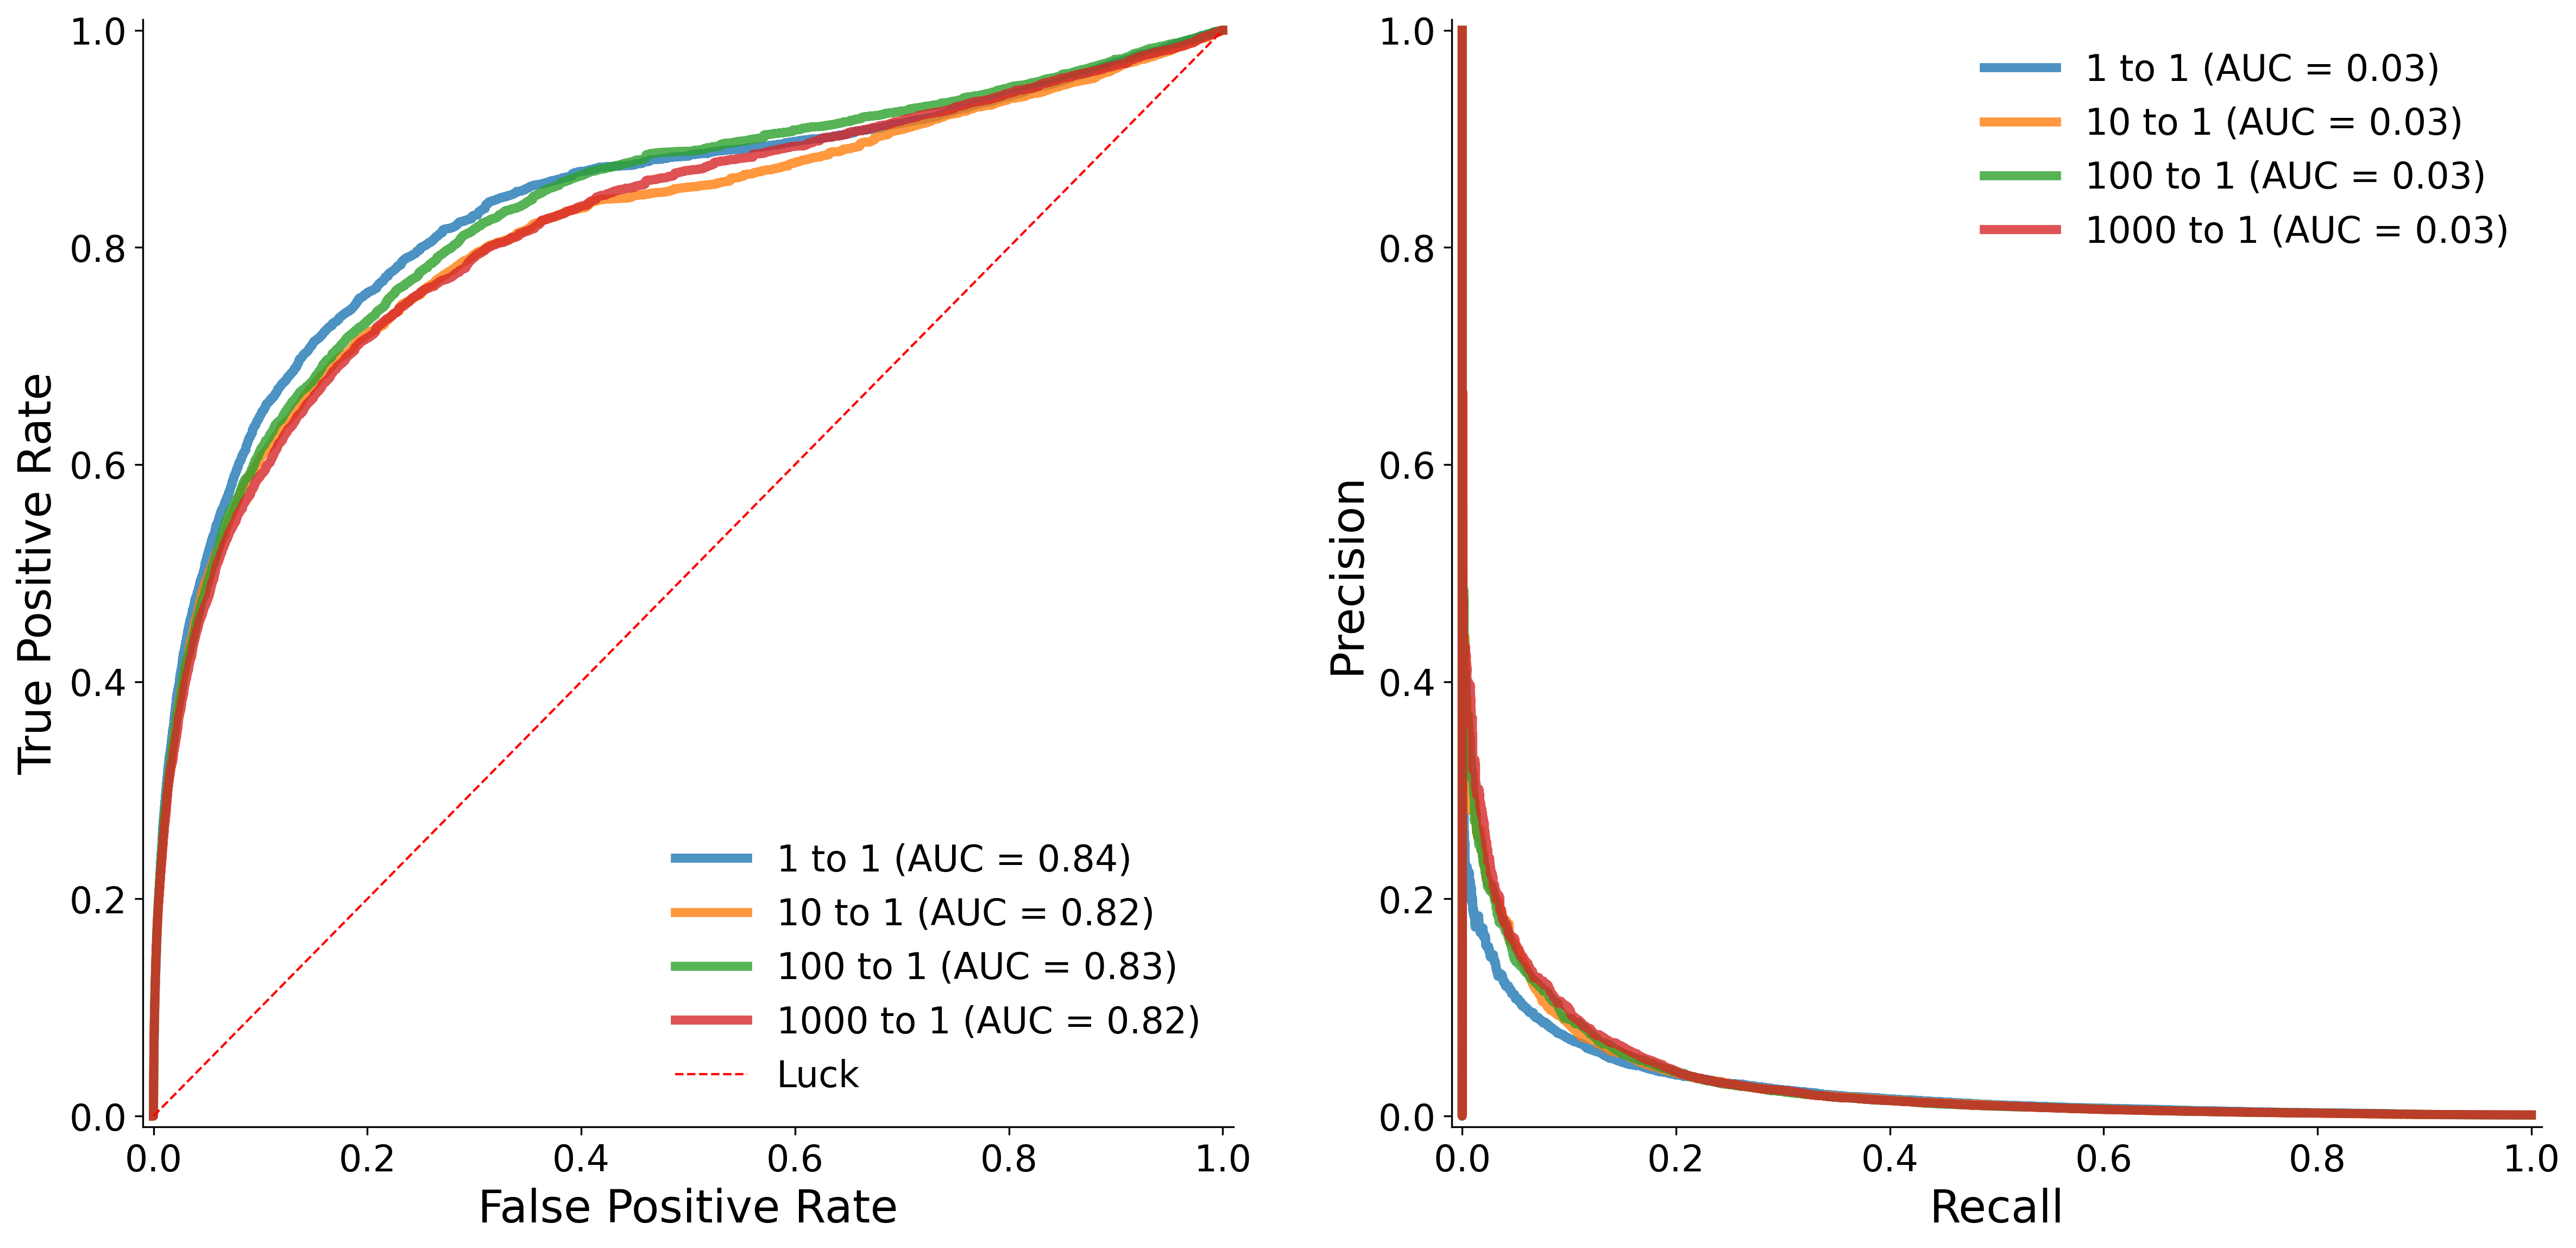

In [48]:
# paper figures

lw = 4
alpha = 0.8

# initialize 1 row, 2 col plot
fig, (ax,ax1) = plt.subplots(1,2, figsize = (19,9))

# panel 1 plot: AUROC
fpr, tpr, thresh = roc_curve(y1, y_proba1, drop_intermediate=False)
ax.plot(fpr, tpr, lw = lw, alpha = alpha, label = f'1 to 1 (AUC = {auc(fpr,tpr):0.2f})')

fpr, tpr, thresh = roc_curve(y10, y_proba10, drop_intermediate=False)
ax.plot(fpr, tpr, lw = lw, alpha = alpha, label = f'10 to 1 (AUC = {auc(fpr,tpr):0.2f})')

fpr, tpr, thresh = roc_curve(y100, y_proba100, drop_intermediate=False)
ax.plot(fpr, tpr, lw = lw, alpha = alpha, label = f'100 to 1 (AUC = {auc(fpr,tpr):0.2f})')

fpr, tpr, thresh = roc_curve(y1000, y_proba1000, drop_intermediate=False)
ax.plot(fpr, tpr, lw = lw, alpha = alpha, label = f'1000 to 1 (AUC = {auc(fpr,tpr):0.2f})')

x = [i for i in np.arange(0.0, 1.01, .01)]
ax.plot(x, x, 'r--', lw=1, label='Luck')


# panel 1 plot configs
size = 24
ax.set_xlabel('False Positive Rate', size = size * 0.8333)
ax.set_ylabel('True Positive Rate', size = size * 0.8333)

ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_xticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize = size * 0.666667)

ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize = size * 0.666667)

ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])

ax.legend(frameon = False,framealpha = 0.01, prop={'size': size * 0.666667})
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



# panel 2 plot: Precision-Recall Curve
pre, rec, thresh = precision_recall_curve(y1,y_proba1)
ax1.plot(rec, pre, lw=lw, alpha = alpha, label = f'1 to 1 (AUC = {auc(rec,pre):0.2f})')

pre, rec, thresh = precision_recall_curve(y10,y_proba10)
ax1.plot(rec, pre, lw=lw, alpha = alpha, label = f'10 to 1 (AUC = {auc(rec,pre):0.2f})')

pre, rec, thresh = precision_recall_curve(y100,y_proba100)
ax1.plot(rec, pre, lw=lw, alpha = alpha, label = f'100 to 1 (AUC = {auc(rec,pre):0.2f})')

pre, rec, thresh = precision_recall_curve(y1000,y_proba1000)
ax1.plot(rec, pre, lw=lw, alpha = alpha, label = f'1000 to 1 (AUC = {auc(rec,pre):0.2f})')


# panel 2 plot configs
ax1.set_xlabel('Recall', size = size * 0.8333)
ax1.set_ylabel('Precision', size = size * 0.8333)

ax1.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.set_xticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize = size * 0.666667)

ax1.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize = size * 0.666667)

ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])

ax1.legend(frameon = False,framealpha = 0.01, prop={'size': size * 0.666667})
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)


plt.show()

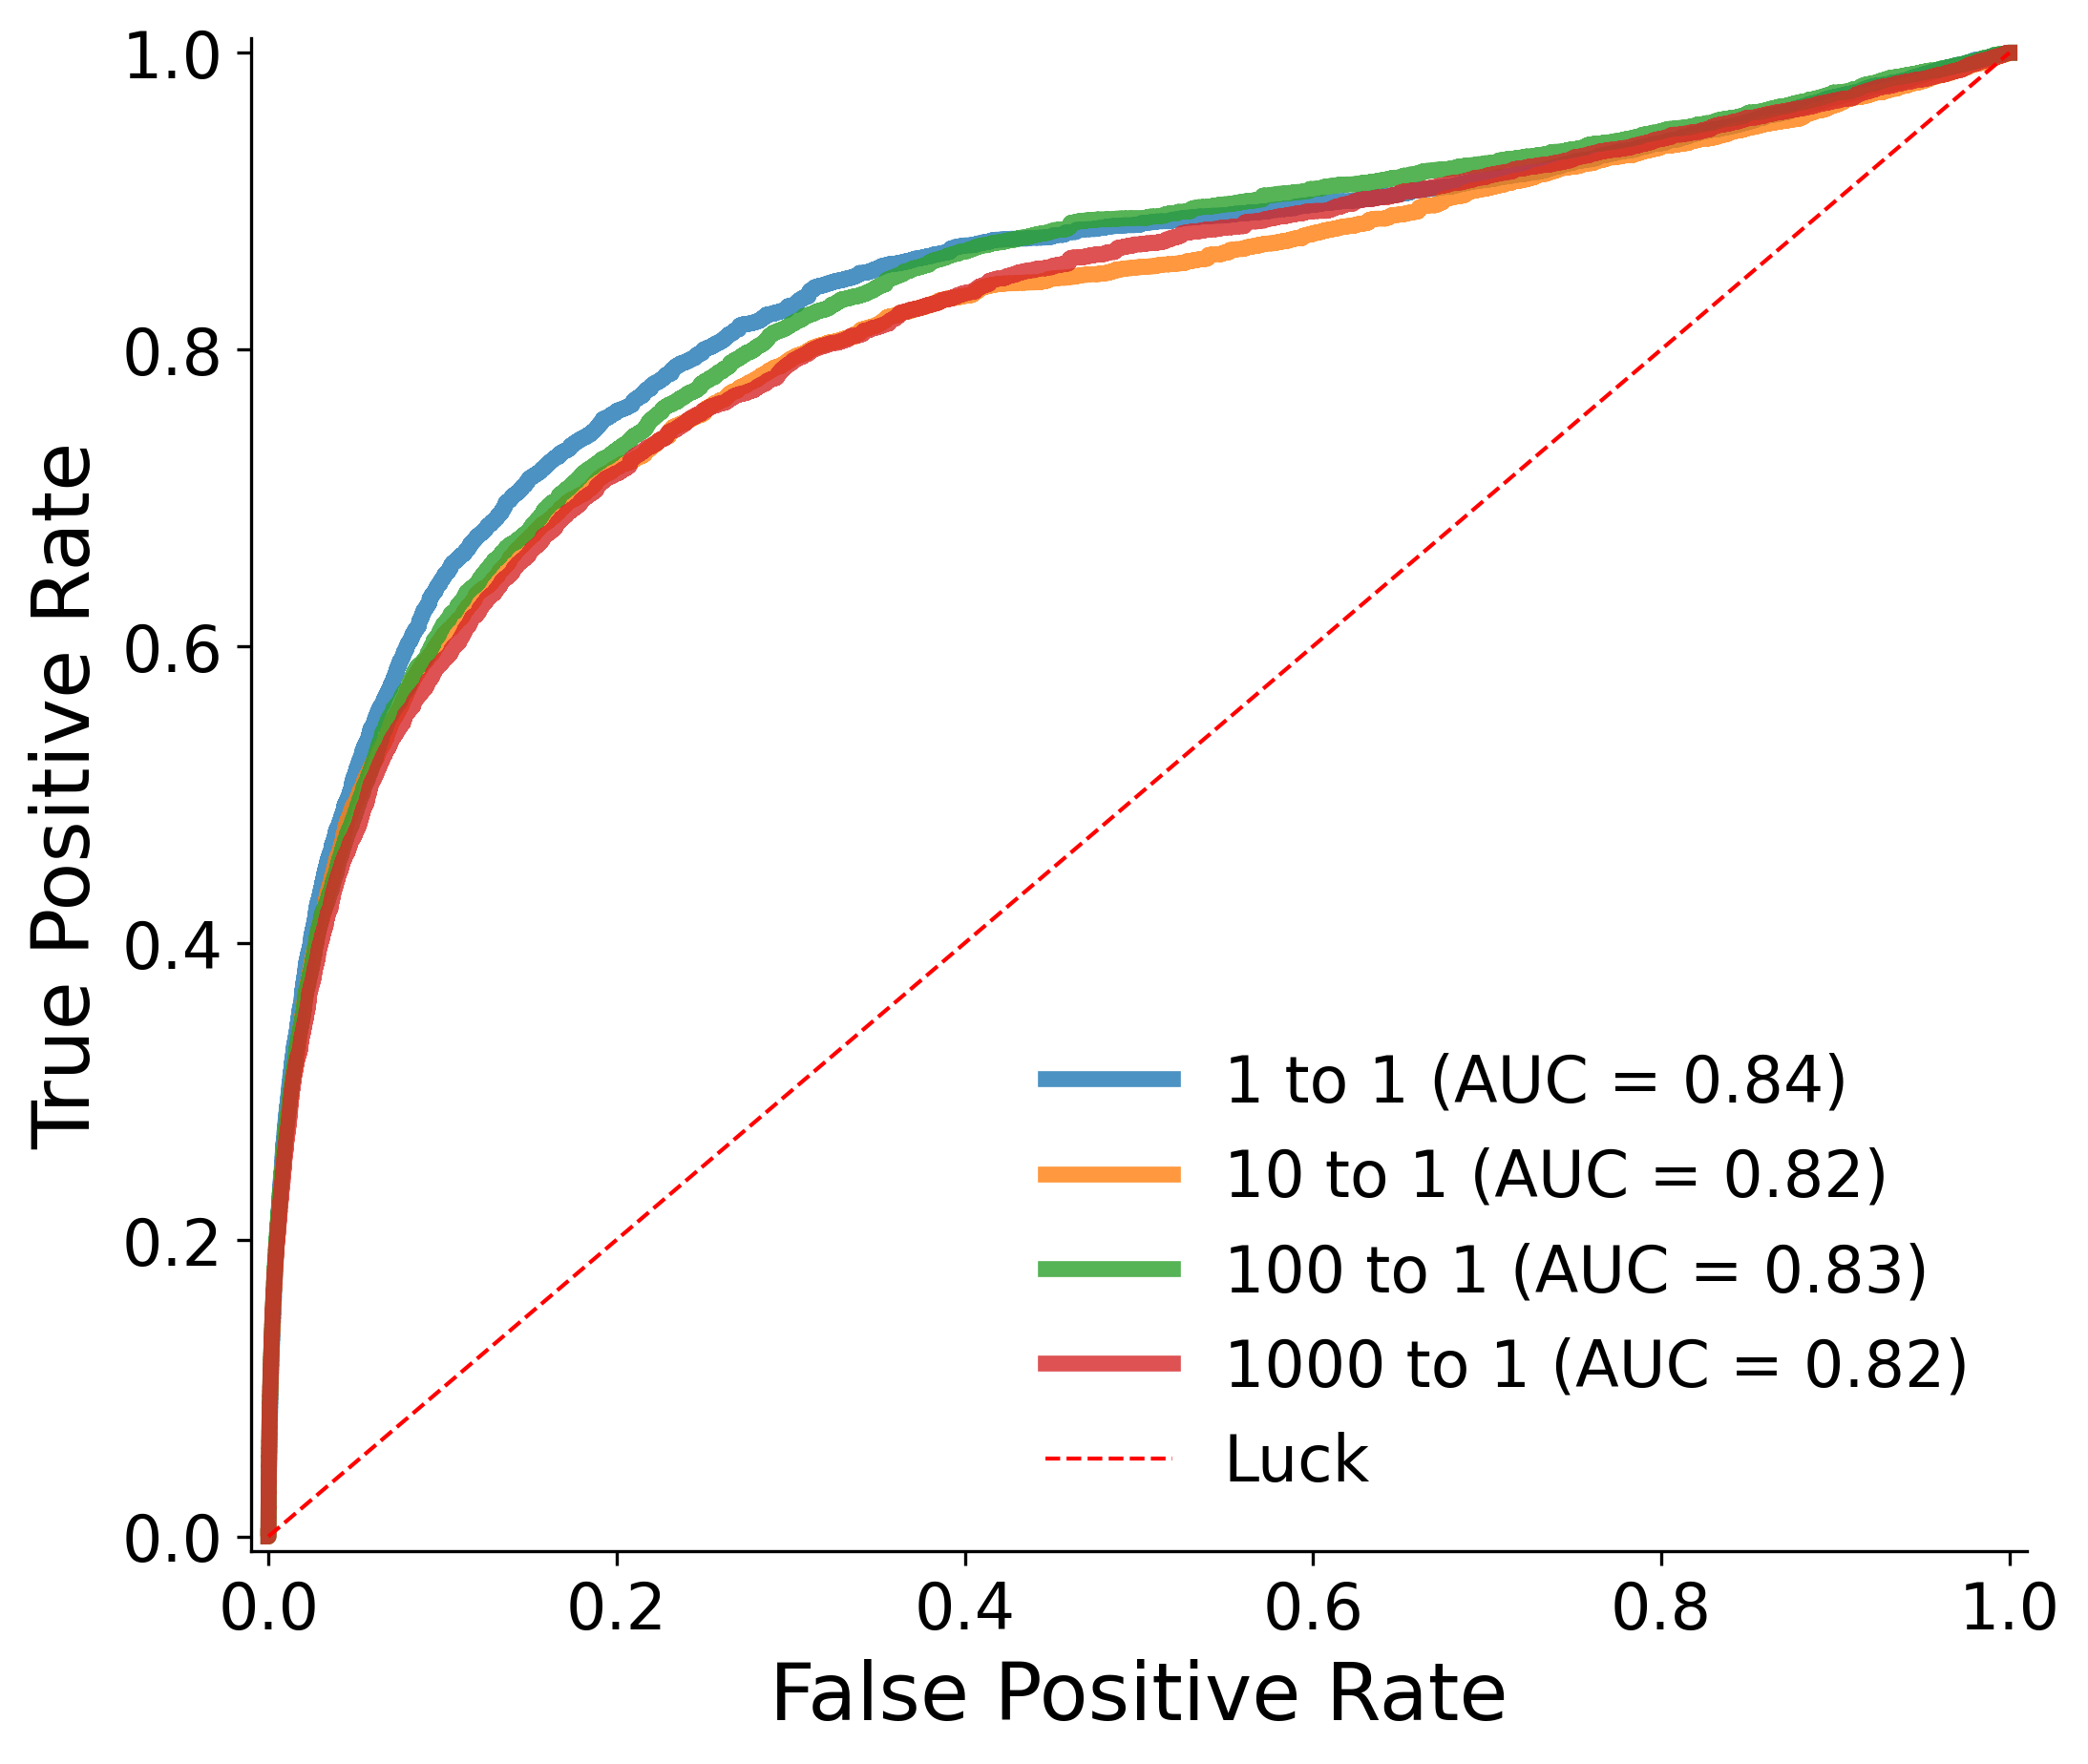

In [49]:
lw = 4
alpha = 0.8

# initialize 1 row, 2 col plot
fig, ax = plt.subplots(figsize = (8,7))

# panel 1 plot: AUROC
fpr, tpr, thresh = roc_curve(y1, y_proba1, drop_intermediate=False)
ax.plot(fpr, tpr, lw = lw, alpha = alpha, label = f'1 to 1 (AUC = {auc(fpr,tpr):0.2f})')

fpr, tpr, thresh = roc_curve(y10, y_proba10, drop_intermediate=False)
ax.plot(fpr, tpr, lw = lw, alpha = alpha, label = f'10 to 1 (AUC = {auc(fpr,tpr):0.2f})')

fpr, tpr, thresh = roc_curve(y100, y_proba100, drop_intermediate=False)
ax.plot(fpr, tpr, lw = lw, alpha = alpha, label = f'100 to 1 (AUC = {auc(fpr,tpr):0.2f})')

fpr, tpr, thresh = roc_curve(y1000, y_proba1000, drop_intermediate=False)
ax.plot(fpr, tpr, lw = lw, alpha = alpha, label = f'1000 to 1 (AUC = {auc(fpr,tpr):0.2f})')

x = [i for i in np.arange(0.0, 1.01, .01)]
ax.plot(x, x, 'r--', lw=1, label='Luck')


# panel 1 plot configs
size = 24
ax.set_xlabel('False Positive Rate', size = size * 0.8333)
ax.set_ylabel('True Positive Rate', size = size * 0.8333)

ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_xticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize = size * 0.666667)

ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize = size * 0.666667)

ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])

ax.legend(frameon = False,framealpha = 0.01, prop={'size': size * 0.666667})
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('f4a.tif', dpi=350, bbox_inches='tight')
plt.show()

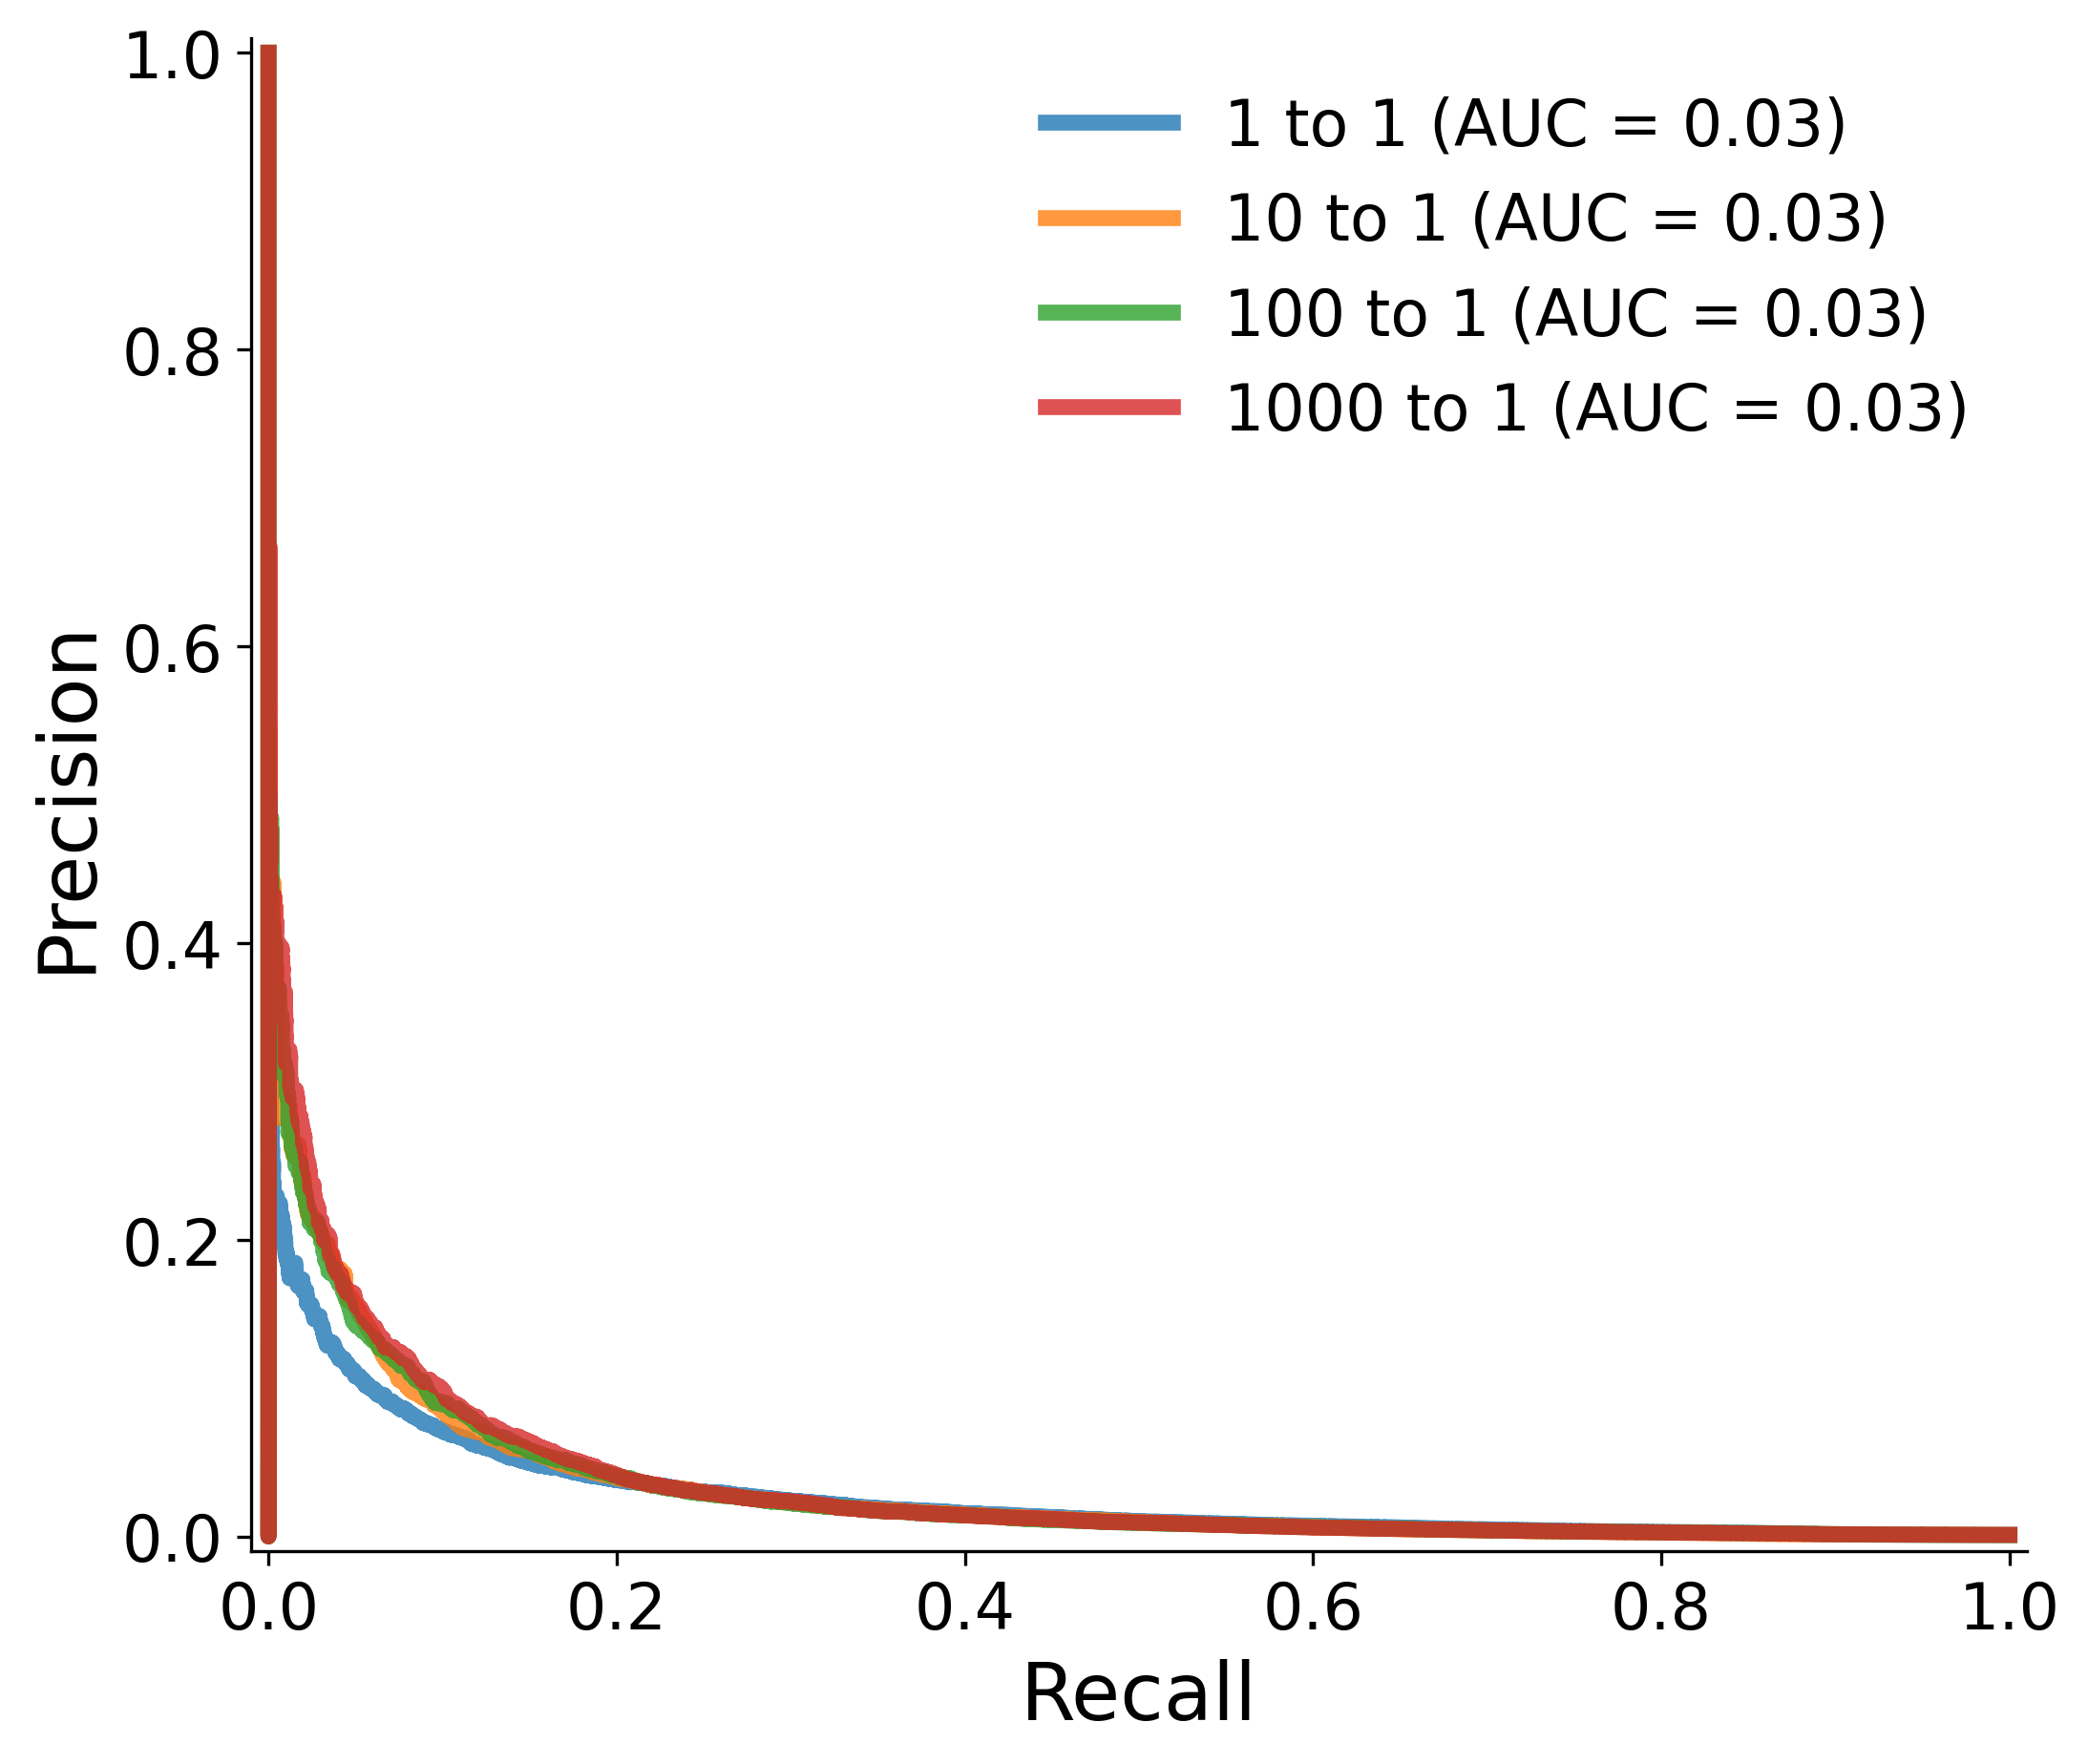

In [50]:
lw = 4
alpha = 0.8

# initialize 1 row, 2 col plot
fig, ax1 = plt.subplots(figsize = (8,7))

# panel 2 plot: Precision-Recall Curve
pre, rec, thresh = precision_recall_curve(y1,y_proba1)
ax1.plot(rec, pre, lw=lw, alpha = alpha, label = f'1 to 1 (AUC = {auc(rec,pre):0.2f})')

pre, rec, thresh = precision_recall_curve(y10,y_proba10)
ax1.plot(rec, pre, lw=lw, alpha = alpha, label = f'10 to 1 (AUC = {auc(rec,pre):0.2f})')

pre, rec, thresh = precision_recall_curve(y100,y_proba100)
ax1.plot(rec, pre, lw=lw, alpha = alpha, label = f'100 to 1 (AUC = {auc(rec,pre):0.2f})')

pre, rec, thresh = precision_recall_curve(y1000,y_proba1000)
ax1.plot(rec, pre, lw=lw, alpha = alpha, label = f'1000 to 1 (AUC = {auc(rec,pre):0.2f})')


# panel 2 plot configs
ax1.set_xlabel('Recall', size = size * 0.8333)
ax1.set_ylabel('Precision', size = size * 0.8333)

ax1.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.set_xticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize = size * 0.666667)

ax1.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize = size * 0.666667)

ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])

ax1.legend(frameon = False,framealpha = 0.01, prop={'size': size * 0.666667})
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

plt.savefig('f4b.tif', dpi=350, bbox_inches='tight')
plt.show()